In [1]:
import numpy as np

In [2]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix
from tqdm import tqdm

c:\Users\thors\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
import sys

root = '../../'
sys.path.append(root)
from HelpfulFunctions.BatchCreation import createBatch

In [4]:
X_train = torch.tensor( np.load( root + "Features/train_features_vgg16_cifar10.npy" ) )
y_train = np.load( root + "Features/train_labels_vgg16_cifar10.npy" )

X_test = torch.tensor( np.load( root + "Features/test_features_vgg16_cifar10.npy" ) )
y_test = np.load( root + "Features/test_labels_vgg16_cifar10.npy" )

----

In [5]:
bits = 32

margin = int(bits / 10)

batchSize = 40
pos_sample_bal = 0.10

In [6]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

No GPU available. Training will run on CPU.


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
model = nn.Sequential(  nn.Linear(4096,256),
                        nn.ReLU(),
                        nn.Linear(256, bits),
                        nn.Sigmoid()
                        )
model = model.to(device)

optimizer = optim.Adam( model.parameters() )
criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=margin
                                 )

------

In [9]:
def getAPN(a, pos, dMatrix):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if (posDist < dMatrix[a][i]) and (dMatrix[a][i] <= posDist+margin)] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [10]:

def customBatch(X_train, y_train, pos_sample_bal, batchSize, pos_label):    
    pos_i = [ i for i in range(len(X_train)) if y_train[i] == pos_label ]
    neg_i = list(set( range(len(X_train)) ) - set(pos_i))

    pos_sample_size = int(batchSize*pos_sample_bal)
    neg_sample_size = batchSize - pos_sample_size

    pos_i = random.sample( pos_i, pos_sample_size)
    neg_i = random.sample( neg_i, neg_sample_size)

    X_sample = torch.stack( [X_train[i] for i in pos_i+neg_i] )
    y_sample = [y_train[i] for i in pos_i+neg_i]
    return X_sample, y_sample

In [11]:
loss_list = []
y_unique = list(set(y_train))
for i in tqdm( range(10000) ):

    if batchSize != None:        
        xBatch, yBatch = customBatch( X_train, y_train, pos_sample_bal, batchSize, random.sample(y_unique,1)[0] )
    else:
        xBatch, yBatch = createBatch(X_train, y_train, batchSize)
    
    xBatch = xBatch.to(device)

    results = model(xBatch)
    results_np = results.cpu().detach().numpy()
    dMatrix = distance_matrix(results_np, results_np, p=1)

    APN_list = []

    for label in set(yBatch):
        pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]
        for anchor_i in pos_i_list:
            pos_i = [j for j in pos_i_list if j != anchor_i]
            APN_list += getAPN(anchor_i, pos_i, dMatrix)

    if len(APN_list) > 0:
        a_list = []
        p_list = []
        n_list = []

        for apn in APN_list:
            a_list.append(results[ apn[0] ])
            p_list.append(results[ apn[1] ])
            n_list.append(results[ apn[2] ])
        
        # === Improve Model ===
        optimizer.zero_grad()

        loss = criterion(torch.stack(a_list).to(device),
                         torch.stack(p_list).to(device),
                         torch.stack(n_list).to(device) )
        
        loss.backward()
        optimizer.step()

        loss_list.append( float(loss) )

    if (i % 1000) == 0: 
        #print(f"Make Bacthes + get results: {t2-t1}\n", f"Distance Matrix: {t3-t2}\n", f"MAke APN List: {t4-t3}\n", f"Back Propegate: {t5-t4}")
        
        if len(loss_list) != 0: print(i, sum(loss_list) / len(loss_list) )
        else: print(i, "Done")
        loss_list = []


  0%|          | 11/10000 [00:00<03:22, 49.26it/s]

0 2.9593429565429688


 10%|█         | 1010/10000 [00:18<03:00, 49.89it/s]

1000 1.9984709453582763


 20%|██        | 2010/10000 [00:39<02:40, 49.72it/s]

2000 1.9172162095308303


 30%|███       | 3008/10000 [00:59<02:21, 49.32it/s]

3000 1.910883017539978


 40%|████      | 4008/10000 [01:20<01:57, 50.95it/s]

4000 1.897035799741745


 50%|█████     | 5006/10000 [01:40<01:43, 48.05it/s]

5000 1.893145263791681


 60%|██████    | 6008/10000 [02:01<01:21, 48.82it/s]

6000 1.8927388414740562


 70%|███████   | 7007/10000 [02:21<01:00, 49.08it/s]

7000 1.9004822412133218


 80%|████████  | 8009/10000 [02:41<00:40, 49.18it/s]

8000 1.8858644136190414


 90%|█████████ | 9007/10000 [03:02<00:19, 49.73it/s]

9000 1.871775414288044


100%|██████████| 10000/10000 [03:22<00:00, 49.34it/s]


----

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

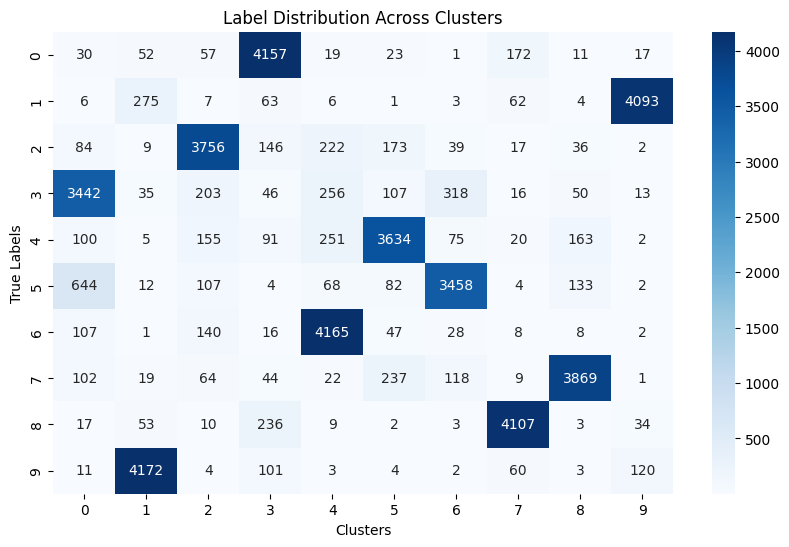

In [14]:
easyHeatmap(model(X_train.to(device)).cpu().detach().numpy(), y_train)

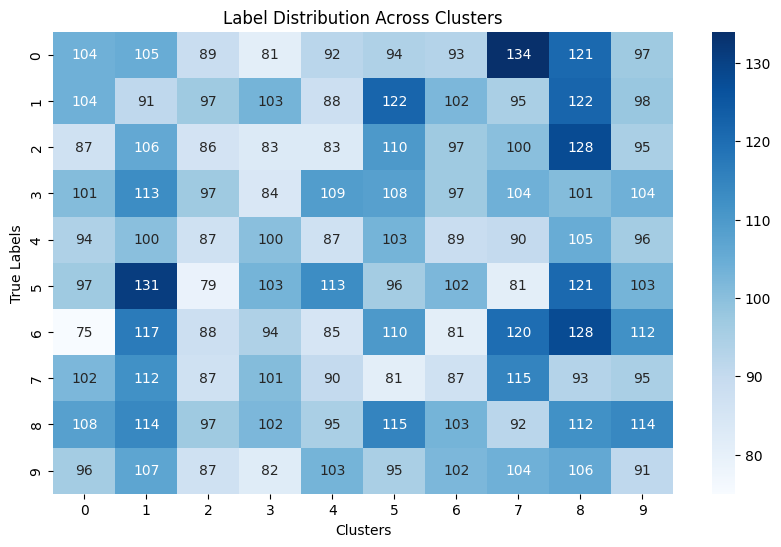

In [16]:
easyHeatmap(model(X_test.to(device)).cpu().detach().numpy(), y_train)

In [17]:
def mean_average_precision(test_hashes, labels):
    aps = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = labels[i]
        distances = np.abs(test_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.drop(index=i)
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df = hash_df[hash_df["tp"]==1]
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        ap = precision.mean()
        aps.append(ap)
    
    return np.array(aps).mean()

In [19]:
res = (model(X_test.to(device)).cpu().detach().numpy() > 0.5).astype(int)
mean_average_precision( res , y_test)

100%|██████████| 10000/10000 [00:42<00:00, 236.25it/s]


0.7518735407409634

In [30]:
data = {}
data["testHash"] = (model(X_test.to(device)).cpu().detach().numpy() > 0.5).astype(int).tolist()
data["y_test"]   = y_test.tolist()

filePath = f"{root}Results/testHash.json"

import json
with open(filePath, "w") as fp:
    json.dump(data , fp)

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)